# Image Segmentation Process

## Initial Setup of directories and required libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import cv2 as cv
import time
import re

import matplotlib.pyplot as plt

from PIL import Image

from scipy import ndimage as ndi
from scipy.ndimage import interpolation as inter

from skimage import filters
from skimage.measure import label, regionprops
from skimage.segmentation import slic, clear_border
from skimage.morphology import remove_small_objects, remove_small_holes, binary_closing, binary_dilation, disk, binary_erosion

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

nbdir = "/content/drive/MyDrive/DSCI 592 Group/"
%cd /content/drive/MyDrive/DSCI\ 592\ Group/

In [ ]:
#Set Directories

#Main - Original
Benign_dir = ['./data/The IQ-OTHNCCD lung cancer dataset/Bengin cases']
Malignant_dir = ['./data/The IQ-OTHNCCD lung cancer dataset/Malignant cases']
Normal_dir = ['./data/The IQ-OTHNCCD lung cancer dataset/Normal cases']

#Main - Pipeline Segmented
Benign_Seg_dir = ['./data/The IQ-OTHNCCD lung cancer dataset/Bengin Segmented']
Malignant_Seg_dir = ['./data/The IQ-OTHNCCD lung cancer dataset/Malignant Segmented']
Normal_Seg_dir = ['./data/The IQ-OTHNCCD lung cancer dataset/Normal Segmented']

#Main - UNET Segmented
Benign_Seg_UNET_dir = ['./data/The IQ-OTHNCCD lung cancer dataset/Bengin UNET Segmented']
Malignant_Seg_UNET_dir = ['./data/The IQ-OTHNCCD lung cancer dataset/Malignant UNET Segmented']
Normal_Seg_UNET_dir = ['./data/The IQ-OTHNCCD lung cancer dataset/Normal UNET Segmented']


#Validation - Original
Adenocarcinoma_DLCT_dir = ['./data/DLCTLungDetectNet/Unrefined Data/adenocarcinoma']
Squamous_Cell_Carcinoma_DLCT_dir = ['./data/DLCTLungDetectNet/Unrefined Data/squamous.cell.carcinoma']
Large_Cell_Carcinoma_DLCT_dir = ['./data/DLCTLungDetectNet/Unrefined Data/large.cell.carcinoma']
Normal_DLCT_dir = ['./data/DLCTLungDetectNet/Unrefined Data/normal']

#Validation - Pipeline Segmented
Adenocarcinoma_DLCT_Seg_dir = ['./data/DLCTLungDetectNet/Unrefined Data/adenocarcinoma Segmented']
Squamous_Cell_Carcinoma_DLCT_Seg_dir = ['./data/DLCTLungDetectNet/Unrefined Data/squamous.cell.carcinoma Segmented']
Large_Cell_Carcinoma_DLCT_Seg_dir = ['./data/DLCTLungDetectNet/Unrefined Data/large.cell.carcinoma Segmented']
Normal_DLCT_Seg_dir = ['./data/DLCTLungDetectNet/Unrefined Data/normal Segmented']

#Validation - UNET Segmented
Adenocarcinoma_Seg_UNET_DLCT_dir = ['./data/DLCTLungDetectNet/Unrefined Data/adenocarcinoma UNET Segmented']
Squamous_Cell_Carcinoma_Seg_UNET_DLCT_dir = ['./data/DLCTLungDetectNet/Unrefined Data/squamous.cell.carcinoma UNET Segmented']
Large_Cell_Carcinoma_Seg_UNET_DLCT_dir = ['./data/DLCTLungDetectNet/Unrefined Data/large.cell.carcinoma UNET Segmented']
Normal_Seg_UNET_DLCT_dir = ['./data/DLCTLungDetectNet/Unrefined Data/normal UNET Segmented']

In [ ]:
# New Function to create a new data frame that contains filename, labels, data format, height, width
# Returns Cancerous labels for cancerous directories and Non_Cancerous labels for normal directories
# Creating data frame for Validation Dataset

directories = [Adenocarcinoma_DLCT_dir, Squamous_Cell_Carcinoma_DLCT_dir, Large_Cell_Carcinoma_DLCT_dir, Normal_DLCT_dir]
labels = ["cancerous", "cancerous", "cancerous", "non_cancerous"]

def get_image_metadata(image_path):
    with Image.open(image_path) as img:
        metadata = {
            "filename": os.path.basename(image_path),
            "format": img.format,
            "width": img.width,
            "height": img.height
        }
    return metadata

def create_labels(image_path, cancerous_dirs, non_cancerous_dirs):
    # Flatten the list of cancerous directories
    flattened_cancerous_dirs = [dir for sublist in cancerous_dirs for dir in sublist]

    if any(image_path.startswith(dir) for dir in flattened_cancerous_dirs):
        return "cancerous"
    # Iterate over each directory in non_cancerous_dirs instead of using 'any'
    elif any(image_path.startswith(dir) for dir in [item for sublist in non_cancerous_dirs for item in sublist]):
        return "non_cancerous"
    else:
        return None

def extract_metadata_with_labels(directories, labels):
    filepaths = []
    all_labels = []

    for i, dir_list in enumerate(directories):
        for directory in dir_list:
            for root, _, files in os.walk(directory):
                for file in files:
                    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        filepaths.append(os.path.join(root, file))
                        all_labels.append(labels[i])

    Fseries = pd.Series(filepaths, name="filepaths")
    Lseries = pd.Series(all_labels, name="labels")
    Lung_df = pd.concat([Fseries, Lseries], axis=1)
    Lung_df = pd.DataFrame(Lung_df)
    pd.set_option('display.max_colwidth', None)

    width = []
    height = []
    format = []

    for filepath in Lung_df["filepaths"]:
        try:
            metadata = get_image_metadata(filepath)
            width.append(metadata['width'])
            height.append(metadata['height'])
            format.append(metadata['format'])
        except Exception as e:
            print(f"Error processing {filepath}: {e}")
            width.append(None)
            height.append(None)
            format.append(None)

    width_series = pd.Series(width, name="width")
    height_series = pd.Series(height, name="height")
    format_series = pd.Series(format, name="format")

    # Create labels based on directories
    cancerous_dirs = directories[:3]  # Malignant directories
    non_cancerous_dirs = directories[3:]  # Normal directories
    Lung_df["labels"] = Lung_df["filepaths"].apply(lambda x: create_labels(x, cancerous_dirs, non_cancerous_dirs))

    Lung_df = pd.concat([Lung_df, width_series, height_series, format_series], axis=1)

    return Lung_df

# Usage
Lung_df_validation = extract_metadata_with_labels(directories, labels)
print(Lung_df_validation.head())

                                                                      filepaths  \
0   ./data/DLCTLungDetectNet/Unrefined Data/adenocarcinoma/adenocarcinoma17.png   
1  ./data/DLCTLungDetectNet/Unrefined Data/adenocarcinoma/adenocarcinoma271.png   
2  ./data/DLCTLungDetectNet/Unrefined Data/adenocarcinoma/adenocarcinoma136.png   
3  ./data/DLCTLungDetectNet/Unrefined Data/adenocarcinoma/adenocarcinoma110.png   
4  ./data/DLCTLungDetectNet/Unrefined Data/adenocarcinoma/adenocarcinoma139.png   

      labels  width  height format  
0  cancerous    429     259    PNG  
1  cancerous    460     341    PNG  
2  cancerous    361     268    PNG  
3  cancerous    416     272    PNG  
4  cancerous    395     303    PNG  


In [ ]:
# New Function to create a new data frame that contains filename, labels, data format, height, width
# Returns Cancerous labels for cancerous directories and Non_Cancerous labels for normal directories
# Creating data frame for Training Dataset

directories = [Malignant_dir, Benign_dir, Normal_dir]
labels = ["cancerous", "non_cancerous", "non_cancerous"]

def get_image_metadata(image_path):
    with Image.open(image_path) as img:
        metadata = {
            "filename": os.path.basename(image_path),
            "format": img.format,
            "width": img.width,
            "height": img.height
        }
    return metadata

def create_labels(image_path, cancerous_dirs, non_cancerous_dirs):
    # Flatten the list of cancerous directories
    flattened_cancerous_dirs = [dir for sublist in cancerous_dirs for dir in sublist]

    if any(image_path.startswith(dir) for dir in flattened_cancerous_dirs):
        return "cancerous"
    # Iterate over each directory in non_cancerous_dirs instead of using 'any'
    elif any(image_path.startswith(dir) for dir in [item for sublist in non_cancerous_dirs for item in sublist]):
        return "non_cancerous"
    else:
        return None

def extract_metadata_with_labels(directories, labels):
    filepaths = []
    all_labels = []

    for i, dir_list in enumerate(directories):
        for directory in dir_list:
            for root, _, files in os.walk(directory):
                for file in files:
                    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        filepaths.append(os.path.join(root, file))
                        all_labels.append(labels[i])

    Fseries = pd.Series(filepaths, name="filepaths")
    Lseries = pd.Series(all_labels, name="labels")
    Lung_df = pd.concat([Fseries, Lseries], axis=1)
    Lung_df = pd.DataFrame(Lung_df)
    pd.set_option('display.max_colwidth', None)

    width = []
    height = []
    format = []

    for filepath in Lung_df["filepaths"]:
        try:
            metadata = get_image_metadata(filepath)
            width.append(metadata['width'])
            height.append(metadata['height'])
            format.append(metadata['format'])
        except Exception as e:
            print(f"Error processing {filepath}: {e}")
            width.append(None)
            height.append(None)
            format.append(None)

    width_series = pd.Series(width, name="width")
    height_series = pd.Series(height, name="height")
    format_series = pd.Series(format, name="format")

    # Create labels based on directories
    cancerous_dirs = directories[:1]  # Malignant directories
    non_cancerous_dirs = directories[1:]  # Benign and Normal directories
    Lung_df["labels"] = Lung_df["filepaths"].apply(lambda x: create_labels(x, cancerous_dirs, non_cancerous_dirs))

    Lung_df = pd.concat([Lung_df, width_series, height_series, format_series], axis=1)

    return Lung_df

# Usage
Lung_df = extract_metadata_with_labels(directories, labels)
print(Lung_df.head())

                                                                            filepaths  \
0  ./data/The IQ-OTHNCCD lung cancer dataset/Malignant cases/Malignant case (257).jpg   
1  ./data/The IQ-OTHNCCD lung cancer dataset/Malignant cases/Malignant case (250).jpg   
2  ./data/The IQ-OTHNCCD lung cancer dataset/Malignant cases/Malignant case (252).jpg   
3  ./data/The IQ-OTHNCCD lung cancer dataset/Malignant cases/Malignant case (254).jpg   
4  ./data/The IQ-OTHNCCD lung cancer dataset/Malignant cases/Malignant case (249).jpg   

      labels  width  height format  
0  cancerous    512     512   JPEG  
1  cancerous    512     512   JPEG  
2  cancerous    512     512   JPEG  
3  cancerous    512     512   JPEG  
4  cancerous    512     512   JPEG  


## Pipeline Segmentation Approach (SKIMAGE)

In [ ]:
def determine_score(arr, angle):
    data = inter.rotate(arr, angle, reshape=False, order=0)
    histogram = np.sum(data, axis=1, dtype=float)
    score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
    return histogram, score


def correct_skew(image, delta=1, limit=5):
    thresh = cv.threshold(image, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)
    best_angle = angles[scores.index(max(scores))]
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv.getRotationMatrix2D(center, best_angle, 1.0)
    corrected = cv.warpAffine(image, M, (w, h), flags=cv.INTER_CUBIC, \
            borderMode=cv.BORDER_REPLICATE)
    return best_angle, corrected


def bit_plane_slice(image):
    bit_planes = []
    for i in range(8):
        mask = 2 ** i
        bit_plane = np.bitwise_and(image, mask)
        bit_planes.append(bit_plane)
    return bit_planes


def reconstruct_image(bit_planes):
    reconstructed_image = np.zeros_like(bit_planes[0])
    for i in range(6):
        reconstructed_image = np.bitwise_or(reconstructed_image, bit_planes[-i])
    return reconstructed_image


def isolate_lung_area(image):
    label_image = label(image)
    regions = regionprops(label_image)
    image_height = image.shape[0]

    filtered_regions = [region for region in regions if region.area >= 600 and region.centroid[0] <= image_height * 0.75]
    regions = sorted(filtered_regions, key=lambda x: x.area, reverse=True)

    if len(regions) > 3:
      top_n_regions = sorted(regions, key=lambda x: x.centroid[0])
      top_n_highest_regions = top_n_regions[:-2]
    elif len(regions) > 2:
      top_n_regions = sorted(regions, key=lambda x: x.centroid[0])
      top_n_highest_regions = top_n_regions[:-1]
    else:
      top_n_highest_regions = regions

    mask = np.zeros_like(label_image, dtype=bool)
    for region in top_n_highest_regions:
        for coordinates in region.coords:
          mask[coordinates[0], coordinates[1]] = 1
    return mask

def normalize_brightness(image, target_brightness=128):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    current_brightness = np.mean(gray)
    ratio = target_brightness / current_brightness
    image_normalized = cv.convertScaleAbs(image, alpha=ratio, beta=0)
    return image_normalized

In [ ]:
def pipeline(image):
    camera =  cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    angle, corrected = correct_skew(camera)
    bit_planes = bit_plane_slice(corrected)
    bit_plane_reconstructed = reconstruct_image(bit_planes)
    gauss = cv.GaussianBlur(bit_plane_reconstructed, (5, 5), 5)
    thresh_val = filters.threshold_otsu(gauss)
    thresh = gauss<thresh_val

    cleared = clear_border(thresh)

    cleared = isolate_lung_area(cleared)
    cleared = binary_dilation(cleared, footprint=disk(8))
    cleared = remove_small_objects(cleared,min_size=650)
    cleared = remove_small_holes(cleared,area_threshold=900)
    selem = disk(3, dtype=bool)
    cleared = binary_closing(cleared,disk(8))
    cleared = ndi.binary_fill_holes(cleared)
    cleared = binary_erosion(cleared, selem)

    cleared = binary_closing(cleared,disk(12))

    result1 = gauss.copy()
    result1[cleared == 0] = 0
    result1[cleared != 0] = gauss[cleared != 0]
    return result1, cleared

### Output pipeline segmented images
NOTE: processing & exporting 1,000+ CT Scans can take over a half hour depending on computer resources. The portion of code that exports the final segmented images needs to be uncommented before it will output.

In [ ]:
#Output Segmented Images - Original Dataset
for value in Lung_df["filepaths"]:
  file_name = value.rsplit('/', 1)[-1]
  #print(type(file_name))
  category = file_name.split()[0]
  #print(type(category))

  if category == "Bengin":
    output_directory = Benign_Seg_dir
  elif category == "Malignant":
    output_directory = Malignant_Seg_dir
  elif category == "Normal":
    output_directory = Normal_Seg_dir
  else:
    print("Error", category)
    break

  image = cv.imread(value)
  processed_image = pipeline(image)

  output_path = os.path.join(output_directory[0], file_name)
  #cv.imwrite(output_path, processed_image)

In [ ]:
#Output Segmented Images - Validation Dataset
for value in Lung_df_validation["filepaths"]:
  file_name = value.rsplit('/', 1)[-1]
  result = re.match(r'^[^\d]+', file_name)

  if result.group(0) == "adenocarcinoma":
    output_directory = Adenocarcinoma_DLCT_Seg_dir
  elif result.group(0) == "squamous.cell.carcinoma":
    output_directory = Squamous_Cell_Carcinoma_DLCT_Seg_dir
  elif result.group(0) == "large.cell.carcinoma":
    output_directory = Large_Cell_Carcinoma_DLCT_Seg_dir
  elif result.group(0) == "normal":
    output_directory = Normal_DLCT_Seg_dir
  else:
    print("Error", result.group(0))
    break

  image = cv.imread(value)
  processed_image, mask = pipeline(image)

  output_path = os.path.join(output_directory[0], file_name)
  #cv.imwrite(output_path, processed_image)

### Select well segmented images for UNET training
NOTE: Lines of code that create the ouput path and export the given image need to be updated to desired path and uncommented before running.

In [ ]:
def display_segmented(image_path):
    image = cv.imread(image_path)

    resized_image = cv.resize(image, (512, 512))
    segmented_image, mask = pipeline(resized_image)
    normalized_brightness_image = normalize_brightness(resized_image)
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(normalized_brightness_image)
    ax[0].set_title('Original Image')
    ax[1].imshow(segmented_image, cmap='gray')
    ax[1].set_title('Segmented Image')
    ax[2].imshow(mask, cmap='gray')
    ax[2].set_title('Final Mask')
    plt.axis('off')
    plt.show()

    time.sleep(1) # any brief amount of time seems to work
    cv.destroyAllWindows()
    cv.waitKey(0)

    clean = input("\nIs the segmentation quality good? (y/n)\n").lower().strip()
    return clean, normalized_brightness_image, mask

def select_good_segmentation(dataset):
  count_good =0
  for value in dataset:
    clean, image, mask = display_segmented(value)
    file_name = value.rsplit('/', 1)[-1]
    print(file_name)

    if clean == 'y':
      count_good += 1
      print("good", count_good)
      #mask_output_path = os.path.join('/content/drive/MyDrive/DSCI 592 Group/data/UNET/mask', file_name)
      #image_output_path = os.path.join('/content/drive/MyDrive/DSCI 592 Group/data/UNET/image', file_name)
      #mask_output_path = os.path.join('/content/drive/MyDrive/DSCI 592 Group/data/UNET/mask_val', file_name)
      #image_output_path = os.path.join('/content/drive/MyDrive/DSCI 592 Group/data/UNET/image_val', file_name)
      mask = mask.astype(np.uint8) * 255
      #cv.imwrite(mask_output_path, mask)
      #cv.imwrite(image_output_path, image)
    elif clean == 'x':
      break
    else:
      print("bad")

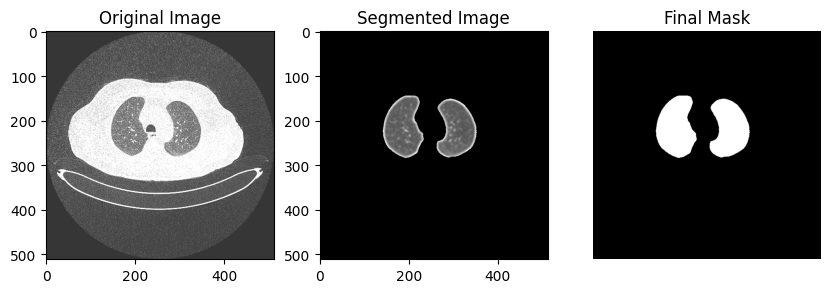


Is the segmentation quality good? (y/n)
x
Normal case (109).jpg


In [ ]:
select_good_segmentation(Lung_df['filepaths'])

### View Pipeline outputs applied over a range of scans

In [ ]:
#Subset Dataset to groups of ~100 Scans
Lung_df_100 = Lung_df[0:99]
Lung_df_200 = Lung_df[100:199]
Lung_df_300 = Lung_df[200:299]
Lung_df_400 = Lung_df[300:399]
Lung_df_500 = Lung_df[400:499]
Lung_df_600 = Lung_df[500:599]
Lung_df_700 = Lung_df[600:699]
Lung_df_800 = Lung_df[700:799]
Lung_df_900 = Lung_df[800:899]
Lung_df_1000 = Lung_df[900:999]
Lung_df_1100 = Lung_df[1000:1099]
Lung_df_1200 = Lung_df[1100:]

Lung_df_validation_100 = Lung_df_validation[0:99]
Lung_df_validation_200 = Lung_df_validation[100:199]
Lung_df_validation_300 = Lung_df_validation[200:299]
Lung_df_validation_400 = Lung_df_validation[300:399]
Lung_df_validation_500 = Lung_df_validation[400:499]
Lung_df_validation_600 = Lung_df_validation[500:599]
Lung_df_validation_700 = Lung_df_validation[600:699]
Lung_df_validation_800 = Lung_df_validation[700:799]
Lung_df_validation_900 = Lung_df_validation[800:899]
Lung_df_validation_1000 = Lung_df_validation[900:999]
Lung_df_validation_1100 = Lung_df_validation[1000:1099]

In [ ]:
fig, axs = plt.subplots(10, 10, figsize=(15, 15))
axs = axs.flatten()

for index, (ax, value) in enumerate(zip(axs, Lung_df_100["filepaths"])):
    image = cv.imread(value)
    processed_image, mask = pipeline(image)
    ax.imshow(processed_image, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Image {index+1}')

## UNET Segmentation Approach

In [ ]:
#Trained Model can be found here: https://drive.google.com/file/d/1kviV1Rn4MH_moMzqdKtmeUip8eoE-yik/view?usp=sharing
trained_model = tf.keras.models.load_model('./data/UNET/lung_UNET.keras')
trained_model.summary()

In [ ]:
#Function to apply to image that will be masked (1st half of non-UNET pipeline)
#Used so that both segmentation processes will result in a mask applied
#to a tilt corrected / bitplane scliced / gaussian blurred image
def preliminary_pipeline(image):
  camera =  cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  angle, corrected = correct_skew(camera)
  bit_planes = bit_plane_slice(corrected)
  bit_plane_reconstructed = reconstruct_image(bit_planes)
  gauss = cv.GaussianBlur(bit_plane_reconstructed, (5, 5), 5)
  gauss_3d = cv.cvtColor(gauss, cv.COLOR_GRAY2BGR)

  return gauss_3d


#Function to clean output from output UNET Mask
def UNET_clean(y_pred):
  y_pred_2d = y_pred[:,:,0]
  y_pred_2d = binary_dilation(y_pred_2d, footprint=disk(7))
  y_pred_2d = remove_small_objects(y_pred_2d,min_size=900)
  y_pred_2d = remove_small_holes(y_pred_2d,area_threshold=500)
  y_pred_2d = binary_closing(y_pred_2d, disk(4))
  y_pred_2d = remove_small_holes(y_pred_2d,area_threshold=300)
  y_pred_2d = binary_erosion(y_pred_2d, footprint=disk(5))
  y_pred_2d = remove_small_objects(y_pred_2d,min_size=1000)
  y_pred_2d = ndi.binary_fill_holes(y_pred_2d)

  return y_pred_2d

In [ ]:
def UNET_pipeline(image_path):

  original_image = cv.imread(image_path)
  original_image = cv.resize(original_image, (512, 512))
  original_image = preliminary_pipeline(original_image)

  image = cv.imread(image_path, cv.IMREAD_COLOR)
  image = cv.resize(image, (512, 512))
  image = normalize_brightness(image)
  image = image/255.0
  image = np.expand_dims(image, axis=0)

  y_pred = trained_model.predict(image)[0]
  y_pred = y_pred > .1
  y_pred = y_pred * 255
  y_pred_2d = UNET_clean(y_pred)

  result = original_image.copy()
  result[y_pred_2d == 0] = 0

  return result, y_pred_2d

### Output UNET segmented images
NOTE: processing & exporting 1,000+ CT Scans can take over an hour depending on computer resources. The portion of code that exports the final UNET segmented images needs to be uncommented before it will output.

In [ ]:
for value in Lung_df["filepaths"]:
  file_name = value.rsplit('/', 1)[-1]
  category = file_name.split()[0]

  if category == "Bengin":
    output_directory = Benign_Seg_UNET_dir
  elif category == "Malignant":
    output_directory = Malignant_Seg_UNET_dir
  elif category == "Normal":
    output_directory = Normal_Seg_UNET_dir
  else:
    print("Error", category)
    break

  segmented_image, mask = UNET_pipeline(value)

  output_path = os.path.join(output_directory[0], file_name)
  #cv.imwrite(output_path, segmented_image)

In [ ]:
for value in Lung_df_validation["filepaths"]:
  file_name = value.rsplit('/', 1)[-1]
  result = re.match(r'^[^\d]+', file_name)

  if result.group(0) == "adenocarcinoma":
    output_directory = Adenocarcinoma_Seg_UNET_DLCT_dir
  elif result.group(0) == "squamous.cell.carcinoma":
    output_directory = Squamous_Cell_Carcinoma_Seg_UNET_DLCT_dir
  elif result.group(0) == "large.cell.carcinoma":
    output_directory = Large_Cell_Carcinoma_Seg_UNET_DLCT_dir
  elif result.group(0) == "normal":
    output_directory = Normal_Seg_UNET_DLCT_dir
  else:
    print("Error", result.group(0))
    break

  segmented_image, mask = UNET_pipeline(value)

  output_path = os.path.join(output_directory[0], file_name)
  #cv.imwrite(output_path, segmented_image)

### View UNET outputs applied to multiple scans

In [ ]:
def display_segmented(image_path):
  image = cv.imread(image_path, cv.IMREAD_COLOR)
  segmented_image, mask = UNET_pipeline(image_path)

  fig, ax = plt.subplots(1, 3, figsize=(10, 5))
  ax[0].imshow(image)
  ax[0].set_title('Original Image')
  ax[1].imshow(segmented_image, cmap='gray')
  ax[1].set_title('Segmented Image')
  ax[2].imshow(mask, cmap='gray')
  ax[2].set_title('Final Mask')
  plt.axis('off')
  plt.show()

  time.sleep(1)
  cv.destroyAllWindows()
  cv.waitKey(0)

  clean = input("\nNext image? (y/n)\n").lower().strip()
  return clean, image, mask

def visualize_model_segmentation(dataset):
  for value in dataset:
    clean, image, mask = display_segmented(value)
    file_name = value.rsplit('/', 1)[-1]
    print(file_name)

    if clean == 'y':
      print("Next:")
    elif clean == 'n':
      break
    else:
      print("Invalid input. Please enter 'y' or 'n'.")

In [ ]:
visualize_model_segmentation(Lung_df_400['filepaths'])